In [2]:
!pip install -U mxnet-cu101==1.7.0

     |███████████████████████████████▌| 834.1MB 1.2MB/s eta 0:00:10tcmalloc: large alloc 1147494400 bytes == 0x563c2cd24000 @  0x7f239ac94615 0x563bf2cc8cdc 0x563bf2da852a 0x563bf2ccbafd 0x563bf2dbcfed 0x563bf2d3f988 0x563bf2d3a4ae 0x563bf2ccd3ea 0x563bf2d3f7f0 0x563bf2d3a4ae 0x563bf2ccd3ea 0x563bf2d3c32a 0x563bf2dbde36 0x563bf2d3b853 0x563bf2dbde36 0x563bf2d3b853 0x563bf2dbde36 0x563bf2d3b853 0x563bf2dbde36 0x563bf2d3b853 0x563bf2ccd30a 0x563bf2d3b60e 0x563bf2d3a7ad 0x563bf2ccd3ea 0x563bf2d3b3b5 0x563bf2ccd30a 0x563bf2d3b3b5 0x563bf2d3a4ae 0x563bf2ccd3ea 0x563bf2d3c32a 0x563bf2d3a4ae
     |████████████████████████████████| 846.0MB 21kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [ ]:
!pip install d2lzh

In [4]:
import d2lzh as d2l
from mxnet import autograd, gluon, image, init, nd
from mxnet.gluon import model_zoo, nn
import time
from mxnet import np, npx

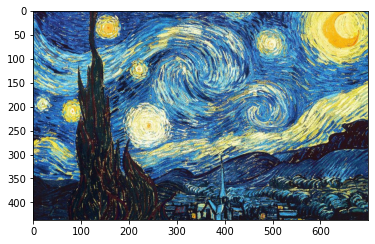

In [5]:
style_img = image.imread('2.png')
d2l.plt.imshow(style_img.asnumpy());

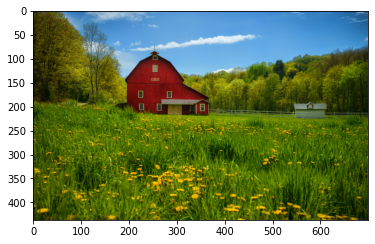

In [6]:
content_img = image.imread('3.png')
d2l.plt.imshow(content_img.asnumpy());

In [7]:
# 图片RGB三通道的均值和标准差
rgb_mean = nd.array([0.485, 0.456, 0.406])
rgb_std = nd.array([0.229, 0.224, 0.225])

def preprocess(img, image_shape):
    img = image.imresize(img, *image_shape)
    img = (img.astype('float32') / 255 - rgb_mean) / rgb_std
    return img.transpose((2, 0, 1)).expand_dims(axis=0)

def postprocess(img):
    img = img[0].as_in_context(rgb_std.context)
    return (img.transpose((1, 2, 0)) * rgb_std + rgb_mean).clip(0, 1)# clip用来确保像素值在0到1之间，因为神经网络可能会迭代一些负数出来哦


In [8]:
pretraind_VGG = model_zoo.vision.vgg19(pretrained=True, root='这里是你的模型参数缓存路径，不设置的话为默认值')
pretraind_VGG.features #查看一下网络的构成（不考虑output层））

HybridSequential(
  (0): Conv2D(3 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Activation(relu)
  (2): Conv2D(64 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): Activation(relu)
  (4): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
  (5): Conv2D(64 -> 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): Activation(relu)
  (7): Conv2D(128 -> 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): Activation(relu)
  (9): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
  (10): Conv2D(128 -> 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): Activation(relu)
  (12): Conv2D(256 -> 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): Activation(relu)
  (14): Conv2D(256 -> 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): Activation(relu)
  (16): Conv2D(256 -> 256

In [9]:
style_layers, content_layers = [0, 5, 10, 12, 19, 28], [29]
net = nn.HybridSequential()
for i in range(max(content_layers + style_layers) + 1):
    net.add(pretraind_VGG.features[i])

In [10]:
def extract_features(X, content_layers, style_layers):
    contents = []
    styles = []
    for i in range(len(net)):
        X = net[i](X)
        if i in style_layers:
            styles.append(X)
        if i in content_layers:
            contents.append(X)
    return contents, styles
def get_contents(image_shape, ctx):
    content_X = preprocess(content_img, image_shape).copyto(ctx)
    contents_Y, _ = extract_features(content_X, content_layers, style_layers)
    return content_X, contents_Y

def get_styles(image_shape, ctx):
    style_X = preprocess(style_img, image_shape).copyto(ctx)
    _, styles_Y = extract_features(style_X, content_layers, style_layers)
    return style_X, styles_Y
def content_loss(Y_hat, Y):
    return (Y_hat - Y).square().mean()
def gram(X):
    num_channels, n = X.shape[1], X.shape[2]*X.shape[3]
    X = X.reshape((num_channels, n))
    return nd.dot(X, X.T) / X.size

def style_loss(Y_hat, gram_Y):
    return (gram(Y_hat) - gram_Y).square().mean()
def tv_loss(Y_hat):
  return 0.5 * ((Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]).abs().mean() +
                (Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]).abs().mean())
def compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram):
    # 分别计算内容损失、样式损失和总变差损失
    contents_l = [content_loss(Y_hat, Y) * content_weight for Y_hat, Y in zip(
        contents_Y_hat, contents_Y)]
    styles_l = [style_loss(Y_hat, Y) * style_weight for Y_hat, Y in zip(
        styles_Y_hat, styles_Y_gram)]
    tv_l = tv_loss(X) * tv_weight
    # 对所有损失求和
    l = nd.add_n(*styles_l) + nd.add_n(*contents_l) + tv_l
    return contents_l, styles_l, tv_l, l
class GeneratedImage(nn.HybridBlock):
    def __init__(self, img_shape, **kwargs):
        super(GeneratedImage, self).__init__(**kwargs)
        self.weight = self.params.get('weight', shape=img_shape)

    def forward(self):
        return self.weight.data()
def get_inits(X, ctx, lr, styles_Y):
    gen_img = GeneratedImage(X.shape)
    gen_img.initialize(init.Constant(X), ctx=ctx, force_reinit=True)
    trainer = gluon.Trainer(gen_img.collect_params(), 'adam', {'learning_rate': lr})
    styles_Y_gram = [gram(Y) for Y in styles_Y]
    return gen_img(), styles_Y_gram, trainer
def train(X, contents_Y, styles_Y, ctx, lr, max_epochs, lr_decay_epoch):
    X, styles_Y_gram, trainer = get_inits(X, ctx, lr, styles_Y)
    for i in range(max_epochs):
        start = time.time()
        with autograd.record():
            contents_Y_hat, styles_Y_hat = extract_features(
                X, content_layers, style_layers)
            contents_l, styles_l, tv_l, l = compute_loss(
                X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram)
        l.backward()
        trainer.step(1)
        nd.waitall()
        if i % 50 == 0 and i != 0:
            print('epoch %3d, content loss %.2f, style loss %.2f, '
                  'TV loss %.2f, %.2f sec'
                  % (i, nd.add_n(*contents_l).asscalar(),
                     nd.add_n(*styles_l).asscalar(), tv_l.asscalar(),
                     time.time() - start))
        if i % lr_decay_epoch == 0 and i != 0:
            trainer.set_learning_rate(trainer.learning_rate * 0.1)
            print('change lr to %.1e' % trainer.learning_rate)
    return X

In [11]:
# 尺寸自己设定
content_weight, style_weight, tv_weight, ctx, image_shape= 1, 3e3, 30, npx.gpu(), (150,100)
net.collect_params().reset_ctx(ctx)
ctx
net.hybridize()
content_X, contents_Y = get_contents(image_shape, ctx)
_, styles_Y = get_styles(image_shape, ctx)
output = train(content_X, contents_Y, styles_Y, ctx, 0.05, 800, 200)

epoch  50, content loss 5.67, style loss 17.98, TV loss 14.55, 0.02 sec
epoch 100, content loss 5.15, style loss 9.55, TV loss 13.49, 0.02 sec
epoch 150, content loss 4.83, style loss 7.04, TV loss 12.47, 0.02 sec
epoch 200, content loss 4.65, style loss 5.98, TV loss 11.72, 0.02 sec
change lr to 5.0e-03
epoch 250, content loss 4.63, style loss 5.89, TV loss 11.62, 0.02 sec
epoch 300, content loss 4.62, style loss 5.81, TV loss 11.54, 0.02 sec
epoch 350, content loss 4.61, style loss 5.73, TV loss 11.46, 0.02 sec
epoch 400, content loss 4.59, style loss 5.65, TV loss 11.39, 0.02 sec
change lr to 5.0e-04
epoch 450, content loss 4.59, style loss 5.64, TV loss 11.38, 0.02 sec
epoch 500, content loss 4.58, style loss 5.64, TV loss 11.37, 0.02 sec
epoch 550, content loss 4.58, style loss 5.63, TV loss 11.36, 0.02 sec
epoch 600, content loss 4.58, style loss 5.62, TV loss 11.35, 0.02 sec
change lr to 5.0e-05
epoch 650, content loss 4.58, style loss 5.62, TV loss 11.35, 0.02 sec
epoch 700, co

In [15]:
# 尺寸自己设定
image_shape = (600,450)
_, content_Y = get_contents(image_shape, ctx)
_, style_Y = get_styles(image_shape, ctx)
X = preprocess(postprocess(output) * 255, image_shape)
output = train(X, content_Y, style_Y, ctx, 0.02, 400, 200)

epoch  50, content loss 1.21, style loss 1.07, TV loss 6.91, 0.07 sec
epoch 100, content loss 1.01, style loss 0.83, TV loss 6.17, 0.07 sec
epoch 150, content loss 0.92, style loss 0.75, TV loss 5.70, 0.07 sec
epoch 200, content loss 0.87, style loss 0.71, TV loss 5.36, 0.07 sec
change lr to 2.0e-03
epoch 250, content loss 0.86, style loss 0.70, TV loss 5.31, 0.07 sec
epoch 300, content loss 0.86, style loss 0.70, TV loss 5.28, 0.07 sec
epoch 350, content loss 0.85, style loss 0.70, TV loss 5.25, 0.07 sec


In [16]:
# 尺寸自己设定
image_shape = (900,600)
_, content_Y = get_contents(image_shape, ctx)
_, style_Y = get_styles(image_shape, ctx)
X = preprocess(postprocess(output) * 255, image_shape)
output = train(X, content_Y, style_Y, ctx, 0.01, 200, 100)

epoch  50, content loss 0.72, style loss 0.69, TV loss 4.75, 0.14 sec
epoch 100, content loss 0.62, style loss 0.53, TV loss 4.34, 0.14 sec
change lr to 1.0e-03
epoch 150, content loss 0.61, style loss 0.52, TV loss 4.29, 0.14 sec


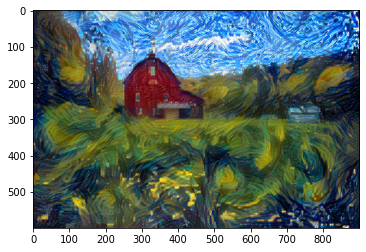

In [17]:
d2l.plt.imshow(postprocess(output).asnumpy())
#d2l.plt.imsave('', postprocess(output).asnumpy())